In [39]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd

frame_length = 32
frame_shift = 16

In [40]:
babble = sf.read('resources/SpeechBabble.wav')
white = sf.read('resources/SpeechWhite.wav')

In [41]:
babble = sf.read("resources/SpeechBabble.wav")
babble_data = babble[0]
sampling_rate_babble = babble[1]

In [42]:
sampling_rate_babble

16000

In [43]:
white = sf.read("resources/SpeechWhite.wav")
white_data = white[0]
sampling_rate_white = white[1]

In [44]:
sampling_rate_white

16000

In [45]:
sampling_rate = sampling_rate_white

In [46]:
babble[0].shape

(69466,)

In [47]:
white[0].shape

(69466,)

In [48]:
sd.play(babble_data,sampling_rate_babble)

In [49]:
sd.play(white_data,sampling_rate_white)

In [50]:
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> [np.ndarray, np.ndarray]:
    millis_per_sample = 1000 / sampling_rate
    frame_length_num_points = frame_length / millis_per_sample
    frame_shift_num_points = frame_shift / millis_per_sample
    num_frames = int(np.floor((len(v_signal) - frame_length_num_points) / frame_shift_num_points) + 1)
    m_frames = np.zeros((num_frames, int(frame_length_num_points)))
    v_time_frame = np.zeros(num_frames)
    for i in range(num_frames):
        start = int(i * frame_shift_num_points)
        end = int(i * frame_shift_num_points + frame_length_num_points)
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + end)/(2*sampling_rate)
    return [m_frames, v_time_frame]

In [51]:
def compute_freq_axis(m_stft: np.ndarray):
    return np.linspace(0, sampling_rate//2, num=m_stft.shape[1])

def remove_upper_half_spectrum(m_stft: np.ndarray) -> np.ndarray:
    m_stft_new = m_stft[:, :(int(m_stft.shape[1]/2)+1)]
    return m_stft_new

In [52]:
def compute_stft(v_signal: np.ndarray, fs: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray) -> [np.ndarray, np.ndarray, np.ndarray]:
    m_frames, v_time_frame = my_windowing(v_signal, fs, frame_length, frame_shift)
    m_stft_full = np.zeros(m_frames.shape, dtype=np.complex128)
    #v_analysis_window = v_analysis_window(m_frames.shape[1])
    for i in range(m_frames.shape[0]):
        m_stft_full[i] = np.fft.fft(m_frames[i]*v_analysis_window)
    #v_freq = np.fft.rfftfreq(m_stft_full.shape[1], 1/fs)
    m_stft = remove_upper_half_spectrum(m_stft_full)
    v_freq = compute_freq_axis(m_stft)
    return [m_stft, v_freq, v_time_frame]

In [53]:
from scipy.signal import get_window

frame_length_samples = (frame_length/1000)*sampling_rate

hann_window = get_window('hann', int(frame_length_samples), fftbins=True)
root_hann = np.sqrt(hann_window)
frame_length_samples

512.0

In [54]:
m_stft_white, v_freq_white, v_time_frame_white = compute_stft(white_data, sampling_rate, frame_length, frame_shift, root_hann)
m_stft_white.shape

(270, 257)

In [55]:
v_freq_white

array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
        218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
        437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
        656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
        875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
       1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
       1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
       1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
       1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
       1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
       2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
       2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
       2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
       2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
       3062.5 , 3093

In [56]:
m_stft_babble, v_freq_babble, v_time_frame_babble = compute_stft(babble_data, sampling_rate, frame_length, frame_shift, root_hann)
m_stft_babble

array([[ 2.65262656e-01+0.00000000e+00j, -2.16367016e-01+6.29985606e-01j,
         5.69587175e-01+4.84045833e-01j, ...,
        -3.93425013e-03-4.05287323e-04j, -3.57753869e-03+2.89133164e-03j,
         1.14449892e-02+0.00000000e+00j],
       [ 3.07412976e+00+0.00000000e+00j, -1.57474320e+00+7.02390530e-01j,
         4.04570767e-01+1.48052866e-01j, ...,
        -1.78363379e-03+3.12659938e-03j, -5.13370028e-03-1.19139963e-03j,
         9.27227385e-03+0.00000000e+00j],
       [ 2.22587410e+00+0.00000000e+00j, -1.01531128e+00-1.06187650e+00j,
        -8.08402214e-03-5.95323847e-02j, ...,
        -6.49308534e-03+7.03539603e-03j,  5.16885917e-03-8.54068974e-04j,
         7.42257688e-04+0.00000000e+00j],
       ...,
       [-5.05450457e-01+0.00000000e+00j,  3.24696469e-01+2.28594171e-01j,
         1.37019834e-01-2.63905007e-01j, ...,
         2.26724951e-03+1.10582116e-02j,  1.30753256e-02-1.12825238e-02j,
        -2.73174294e-02+0.00000000e+00j],
       [ 3.51862939e-01+0.00000000e+00j,  2.

In [57]:
theta = 15

In [58]:
periodogram_white = np.square(np.abs(m_stft_white))
periodogram_white

array([[1.51337449e-01, 7.60558559e-01, 6.27648537e-01, ...,
        1.57686505e-01, 1.32793392e-02, 1.53865722e-01],
       [1.83865883e-01, 3.78208222e-01, 1.47423406e-01, ...,
        9.47418299e-02, 1.82723493e-02, 3.15657594e-03],
       [1.88806798e+00, 4.59051979e-01, 3.84844986e-01, ...,
        3.49856666e-01, 1.59594551e-01, 2.17888192e-01],
       ...,
       [6.79606646e-01, 2.14797833e-01, 5.25303471e-04, ...,
        3.05274841e-02, 2.32418689e-01, 8.54203311e-02],
       [9.46936048e-01, 2.08244429e-01, 2.44087532e-01, ...,
        3.45293477e-01, 3.48998567e-02, 5.81817313e-04],
       [1.09181913e+00, 1.82703124e-01, 1.37270496e-01, ...,
        1.24240514e-01, 6.98600619e-02, 2.76736050e-02]])

In [59]:
periodogram_babble = np.square(np.abs(m_stft_babble))
periodogram_babble

array([[7.03642766e-02, 4.43696550e-01, 5.58729919e-01, ...,
        1.56425819e-05, 2.11585818e-05, 1.30987777e-04],
       [9.45027378e+00, 2.97316860e+00, 1.85597157e-01, ...,
        1.29569732e-05, 2.77743116e-05, 8.59750624e-05],
       [4.95451552e+00, 2.15843871e+00, 3.60945624e-03, ...,
        9.16569545e-05, 2.74465389e-05, 5.50946475e-07],
       ...,
       [2.55480165e-01, 1.57683092e-01, 8.84202876e-02, ...,
        1.27424463e-04, 2.98259483e-04, 7.46241949e-04],
       [1.23807528e-01, 4.06550716e-01, 2.70379495e-01, ...,
        2.70057592e-04, 2.80114385e-04, 7.18812255e-05],
       [9.53905700e-01, 5.57544960e-01, 1.60487582e-01, ...,
        1.48453192e-05, 5.31020276e-04, 2.04393994e-04]])

In [60]:
initial_psd_noise_white = np.mean(np.square(np.abs(m_stft_white[0:m_stft_white.shape[0]//4])), axis=0)
initial_psd_noise_white

array([0.67019398, 0.24674824, 0.1906376 , 0.16948814, 0.19126533,
       0.19256632, 0.22152878, 0.21960998, 0.22860693, 0.18328352,
       0.21178738, 0.19156996, 0.18573179, 0.19566553, 0.25459431,
       0.26065088, 0.24912357, 0.30067219, 0.23046785, 0.21231386,
       0.23384787, 0.24923639, 0.26339014, 0.20306859, 0.21327391,
       0.20185699, 0.22121118, 0.21871148, 0.20869176, 0.21078476,
       0.22772974, 0.19326116, 0.20905667, 0.21379074, 0.24703037,
       0.18225009, 0.22355133, 0.22417391, 0.23078678, 0.19847705,
       0.18753384, 0.1651825 , 0.17649427, 0.19393338, 0.25473145,
       0.25066298, 0.23612835, 0.246023  , 0.20107074, 0.22241297,
       0.19994848, 0.2329886 , 0.24032076, 0.2170578 , 0.19505469,
       0.22142026, 0.25917032, 0.26665839, 0.26333407, 0.18672815,
       0.17247801, 0.18566623, 0.20887968, 0.23092852, 0.20968719,
       0.17357983, 0.20161107, 0.18467589, 0.17712394, 0.19596933,
       0.20842451, 0.19622084, 0.1975942 , 0.2173166 , 0.24772

In [61]:
initial_psd_noise_babble = np.mean(np.square(np.abs(m_stft_babble[0:m_stft_babble.shape[0]//4])), axis=0)
initial_psd_noise_babble

array([2.68716591e+00, 8.53869960e-01, 1.09911298e-01, 6.78335078e-01,
       3.55222982e+00, 5.38775347e+00, 2.91322871e+00, 1.22747236e+00,
       1.33041105e+00, 1.97397573e+00, 3.48596619e+00, 4.61065828e+00,
       1.74407451e+00, 1.12508887e+00, 1.35145413e+00, 1.14936952e+00,
       1.11273273e+00, 1.08464753e+00, 9.19688110e-01, 1.39317375e+00,
       1.10443535e+00, 5.97341925e-01, 6.50005886e-01, 5.30383081e-01,
       2.81993940e-01, 3.10092593e-01, 2.45548539e-01, 2.80344241e-01,
       1.76430965e-01, 7.29172288e-02, 1.12002805e-01, 1.12773399e-01,
       1.08502651e-01, 1.10008721e-01, 1.02030504e-01, 1.33240701e-01,
       3.03620439e-01, 4.12711129e-01, 1.25526767e-01, 1.52932241e-01,
       1.49889644e-01, 1.69703703e-01, 1.18142218e-01, 9.34395382e-02,
       1.17748210e-01, 1.80992345e-01, 1.33376729e-01, 6.71742231e-02,
       4.51094554e-02, 3.89840734e-02, 7.76435440e-02, 6.64348416e-02,
       3.77795641e-02, 2.30086045e-02, 3.39594975e-02, 3.25037110e-02,
      

In [62]:
initial_q = np.zeros(m_stft_white.shape[1])
initial_q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [63]:
def compute_spp_internal(periodogram, initial_psd_noise, theta, l):
    exp_numerator = (-1)*periodogram[l]*theta
    exp_denominator = (initial_psd_noise*(1+theta))
    exp = np.exp(exp_numerator/(exp_denominator))
    arg = 1+(1+theta)*exp
    return 1/arg

In [64]:
def compute_spp(periodogram, initial_psd_noise, initial_q, theta):
    m_spp = np.zeros(periodogram.shape)
    m_noise_psd = np.zeros(periodogram.shape)
    for l in range(periodogram.shape[0]):
        m_spp[l] = compute_spp_internal(periodogram, initial_psd_noise, theta, l)
        initial_q = 0.9*initial_q + 0.1*m_spp[l]
        noise_periodogram = m_spp[l]*initial_psd_noise + (1 - m_spp[l]*periodogram[l])
        m_noise_psd[l] = 0.8*initial_psd_noise + 0.2*noise_periodogram
        initial_psd_noise = m_noise_psd[l]
    return m_spp, m_noise_psd

In [65]:
m_spp_white, m_noise_psd_white= compute_spp(periodogram_white, initial_psd_noise_white, initial_q, theta)
m_spp_white

/var/folders/89/bjtd11g52mxg5l5fn598w6h00000gn/T/ipykernel_42402/4065776803.py:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(exp_numerator/(exp_denominator))


array([[0.07169825, 0.52923962, 0.57786213, ..., 0.15523572, 0.0661004 ,
        0.15241699],
       [0.07304856, 0.14945334, 0.08989259, ..., 0.07690496, 0.06228809,
        0.05935657],
       [0.3616008 , 0.1343046 , 0.12339214, ..., 0.11460445, 0.08141991,
        0.08954378],
       ...,
       [0.10440946, 0.07029634, 0.05884925, ..., 0.06033766, 0.07131361,
        0.06316503],
       [0.1294009 , 0.06991338, 0.07196877, ..., 0.07819763, 0.06055859,
        0.0588521 ],
       [0.14543676, 0.06845245, 0.06591451, ..., 0.06521731, 0.06234209,
        0.06019577]])

In [66]:
np.min(m_noise_psd_white)

-499.63470855314176

In [67]:
m_spp_babble, m_noise_psd_babble= compute_spp(periodogram_babble, initial_psd_noise_babble, initial_q, theta)
m_spp_babble

/var/folders/89/bjtd11g52mxg5l5fn598w6h00000gn/T/ipykernel_42402/4065776803.py:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(exp_numerator/(exp_denominator))


array([[0.06019744, 0.09233639, 0.88007673, ..., 0.06375347, 0.06709209,
        0.10991053],
       [0.72071495, 0.58829021, 0.12567126, ..., 0.05882689, 0.05883073,
        0.05884583],
       [0.81821411, 0.56435672, 0.05933506, ..., 0.05883666, 0.05882746,
        0.05882361],
       ...,
       [0.80134064, 0.06745753, 0.06329819, ..., 0.05882976, 0.05883811,
        0.05886   ],
       [0.09701595, 0.08323888, 0.07352067, ..., 0.05883673, 0.05883722,
        0.05882704],
       [0.40708969, 0.09419339, 0.06718389, ..., 0.05882426, 0.05884949,
        0.05883352]])

In [68]:
np.max(m_noise_psd_babble)

4.572956643489398

1.1) In our case we can listen to the audio and determine that the first second of the audio is noise only. So we can assume there is no contribution from speech to the signal, and thus estimate the initial noise PSD to be the average of the first second audio signal.

For the initial smoothed posterior probability we can initialize it to zero since there is no speech during the first second of the audio signal.

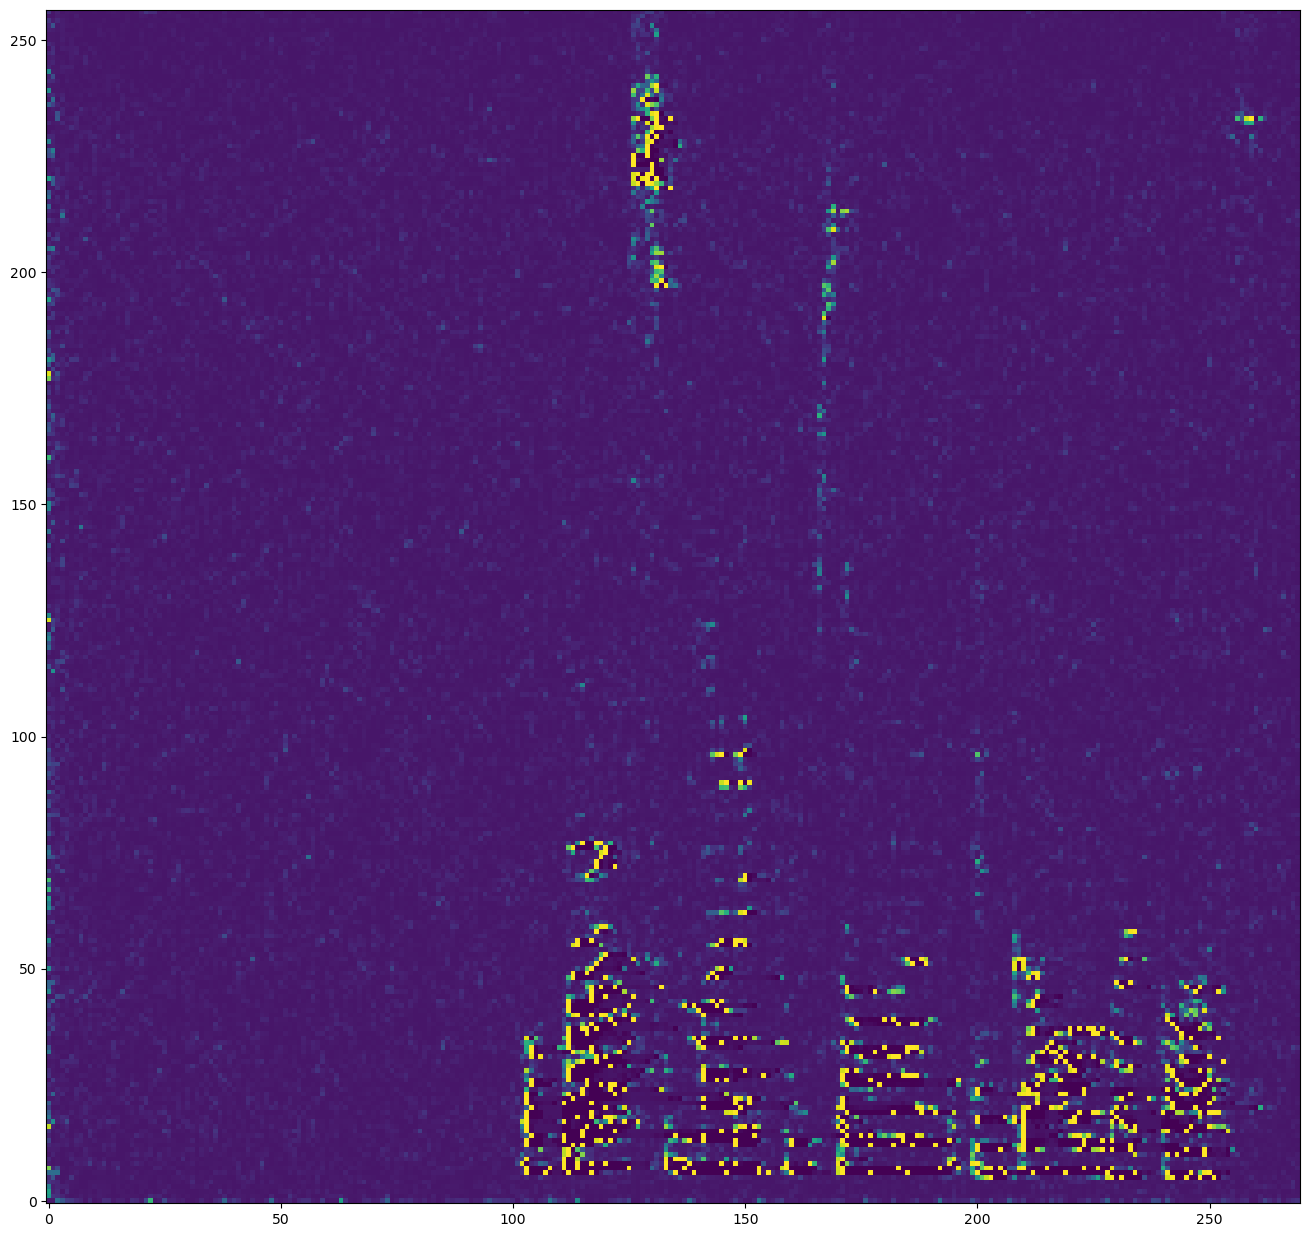

In [69]:
fig = plt.figure()
fig.set_size_inches(26.5, 15.5)
plt.imshow(m_spp_white.T, origin='lower')

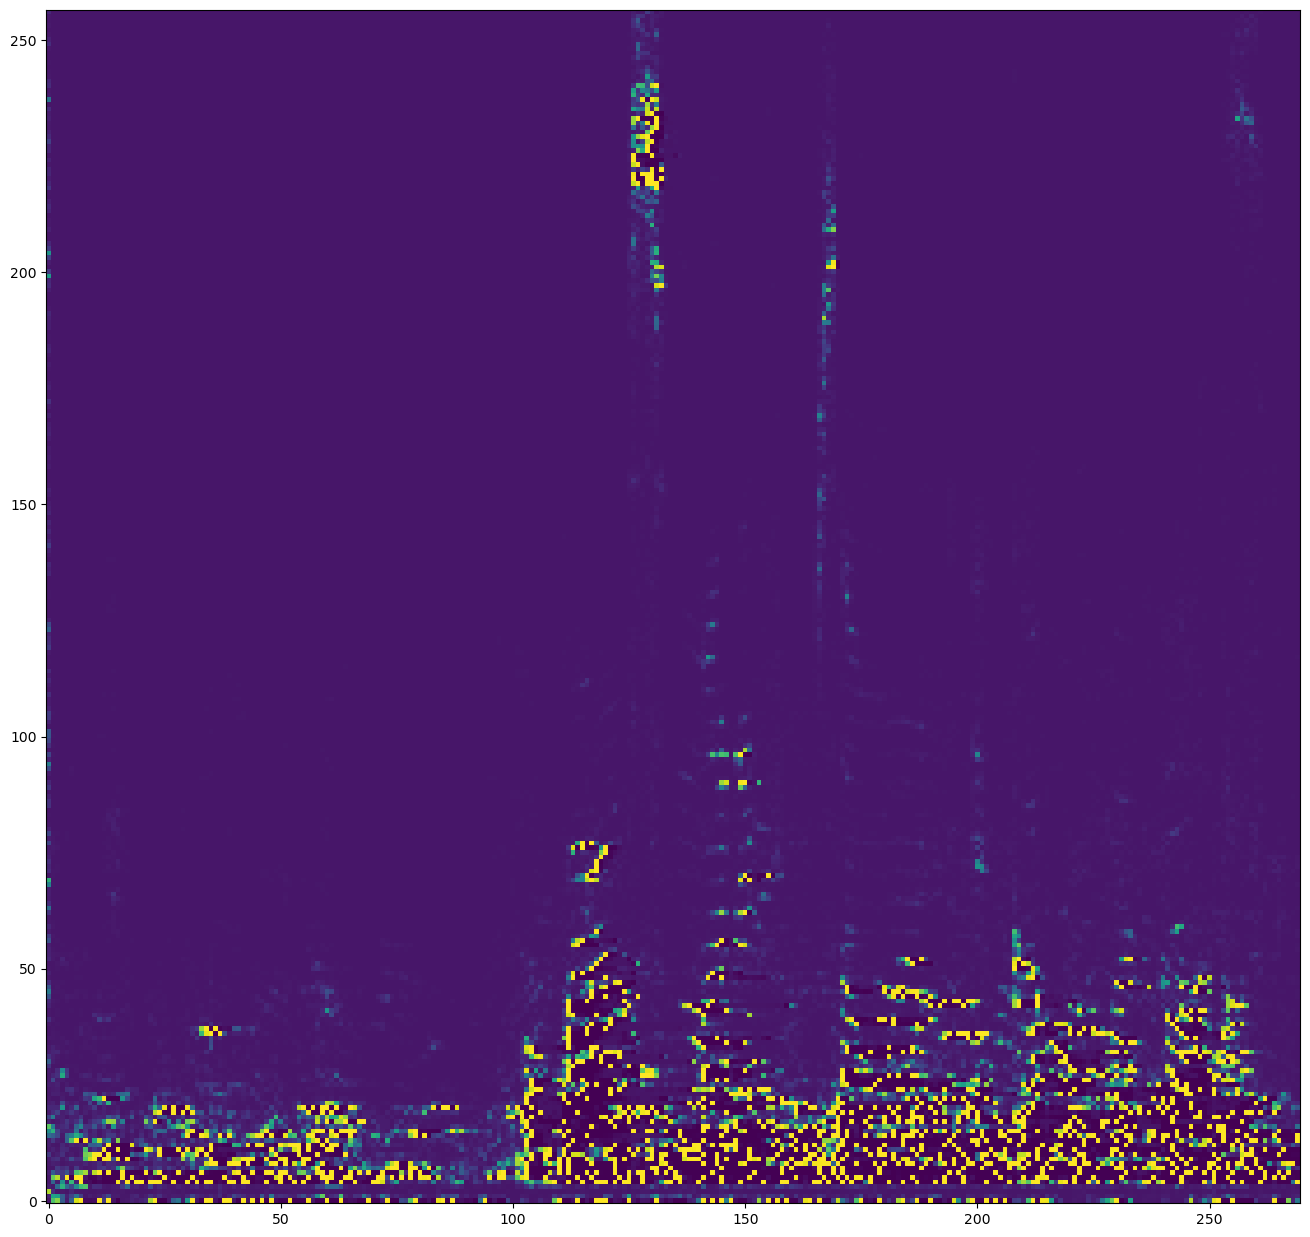

In [70]:
fig = plt.figure()
fig.set_size_inches(26.5, 15.5)
plt.imshow(m_spp_babble.T, origin='lower')

1.2.a) High values, close to 1 for both audios.

1.2.b) For the white noise the values are close to zero in all frequencies. For the babble noise we can see some high values
at lower frequencies and the rest close to zero.

In [71]:
def plot_spectrogram(signal):
    m_stft, v_freq, v_time_frame = compute_stft(signal, sampling_rate, frame_length, frame_shift, analysis_window)

    fig = plt.figure()
    fig.set_size_inches(26.5, 15.5)
    ax = fig.add_subplot(111)
    im = ax.imshow(10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**(-15))),
                   cmap='viridis', origin='lower', extent=[v_time_frame[0], v_time_frame[-1], v_freq[0],
                                                           sampling_rate//2], aspect='auto')
    fig.colorbar(im, orientation="vertical", pad=0.2)

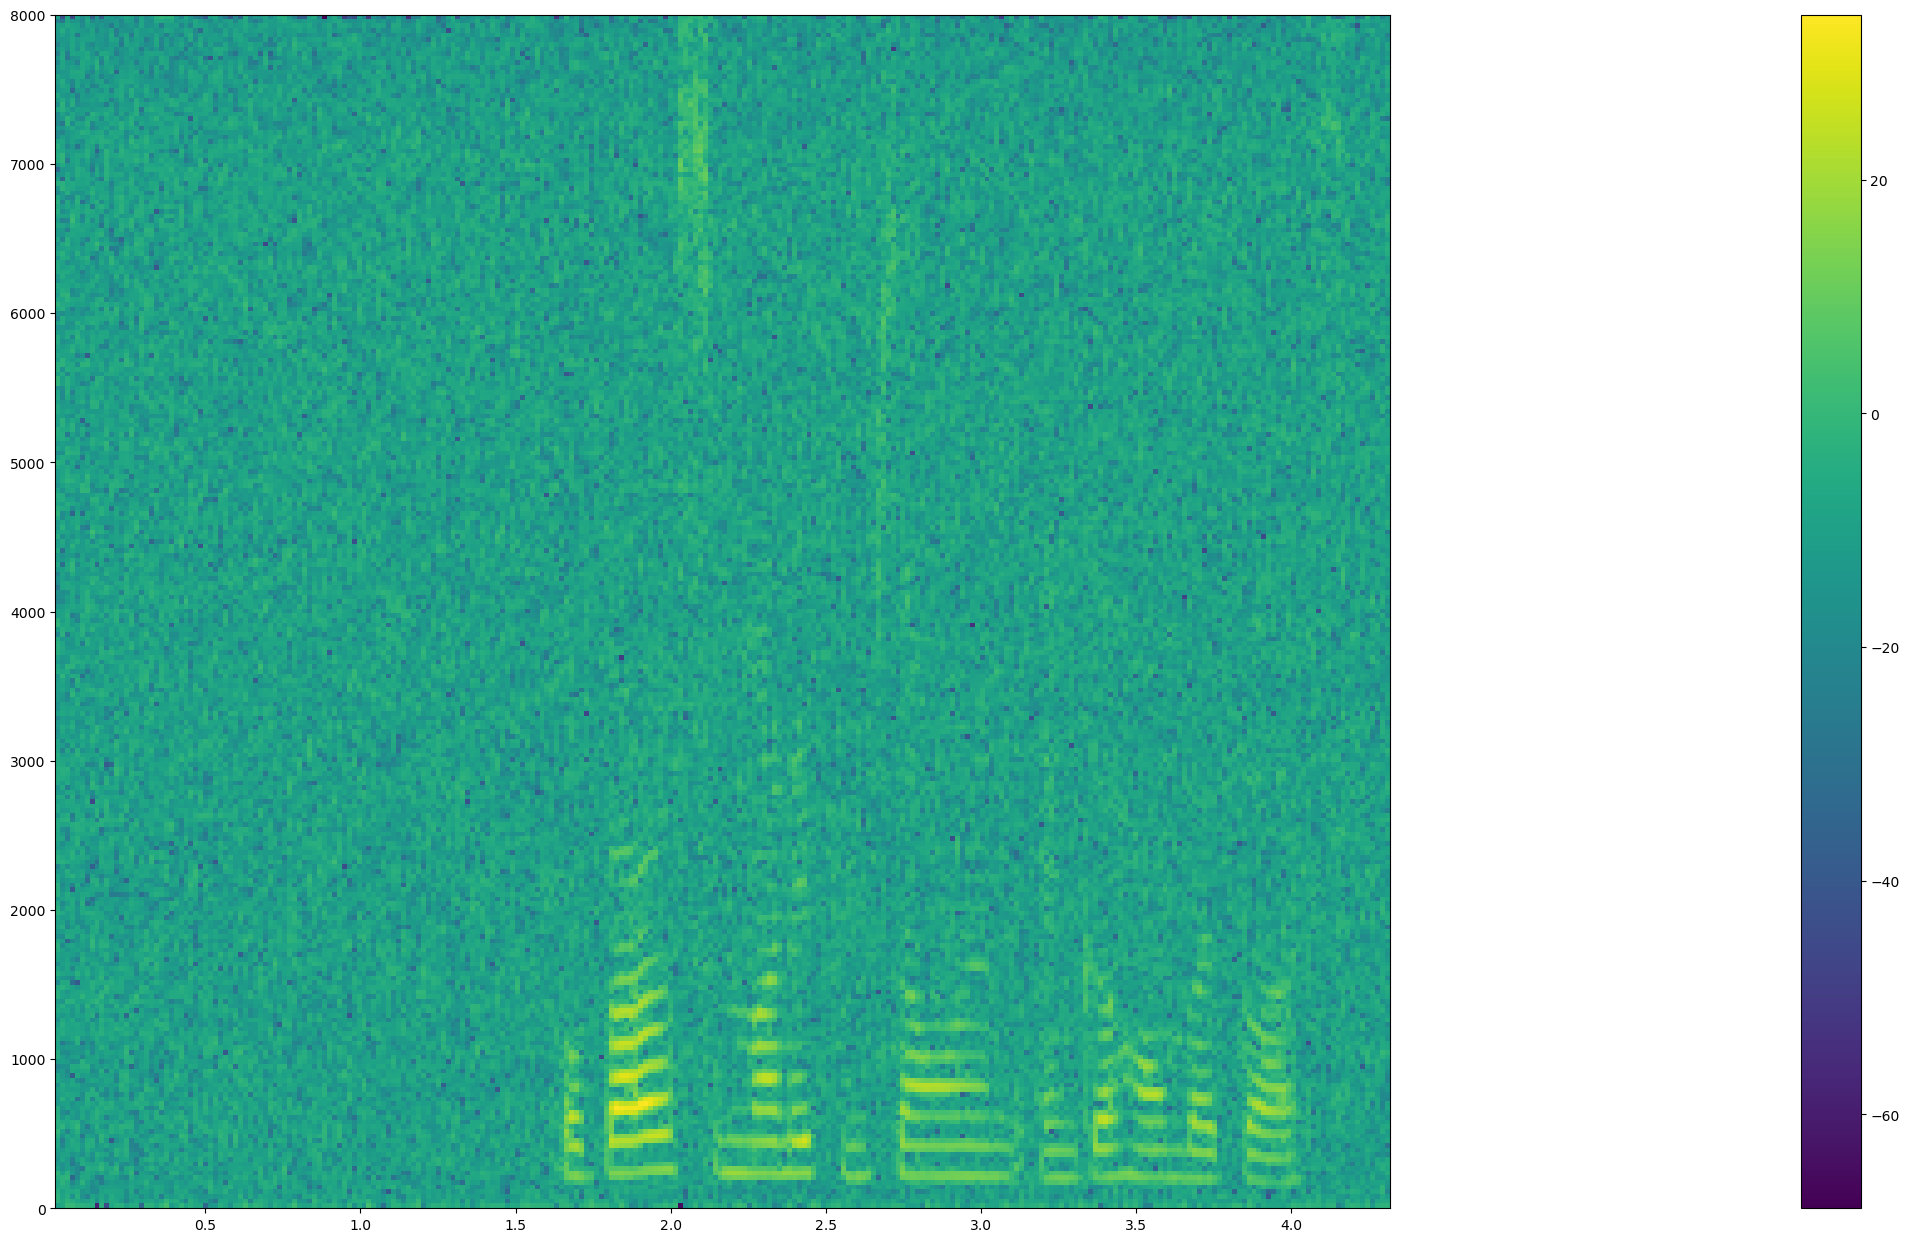

In [72]:
plot_spectrogram(white_data)

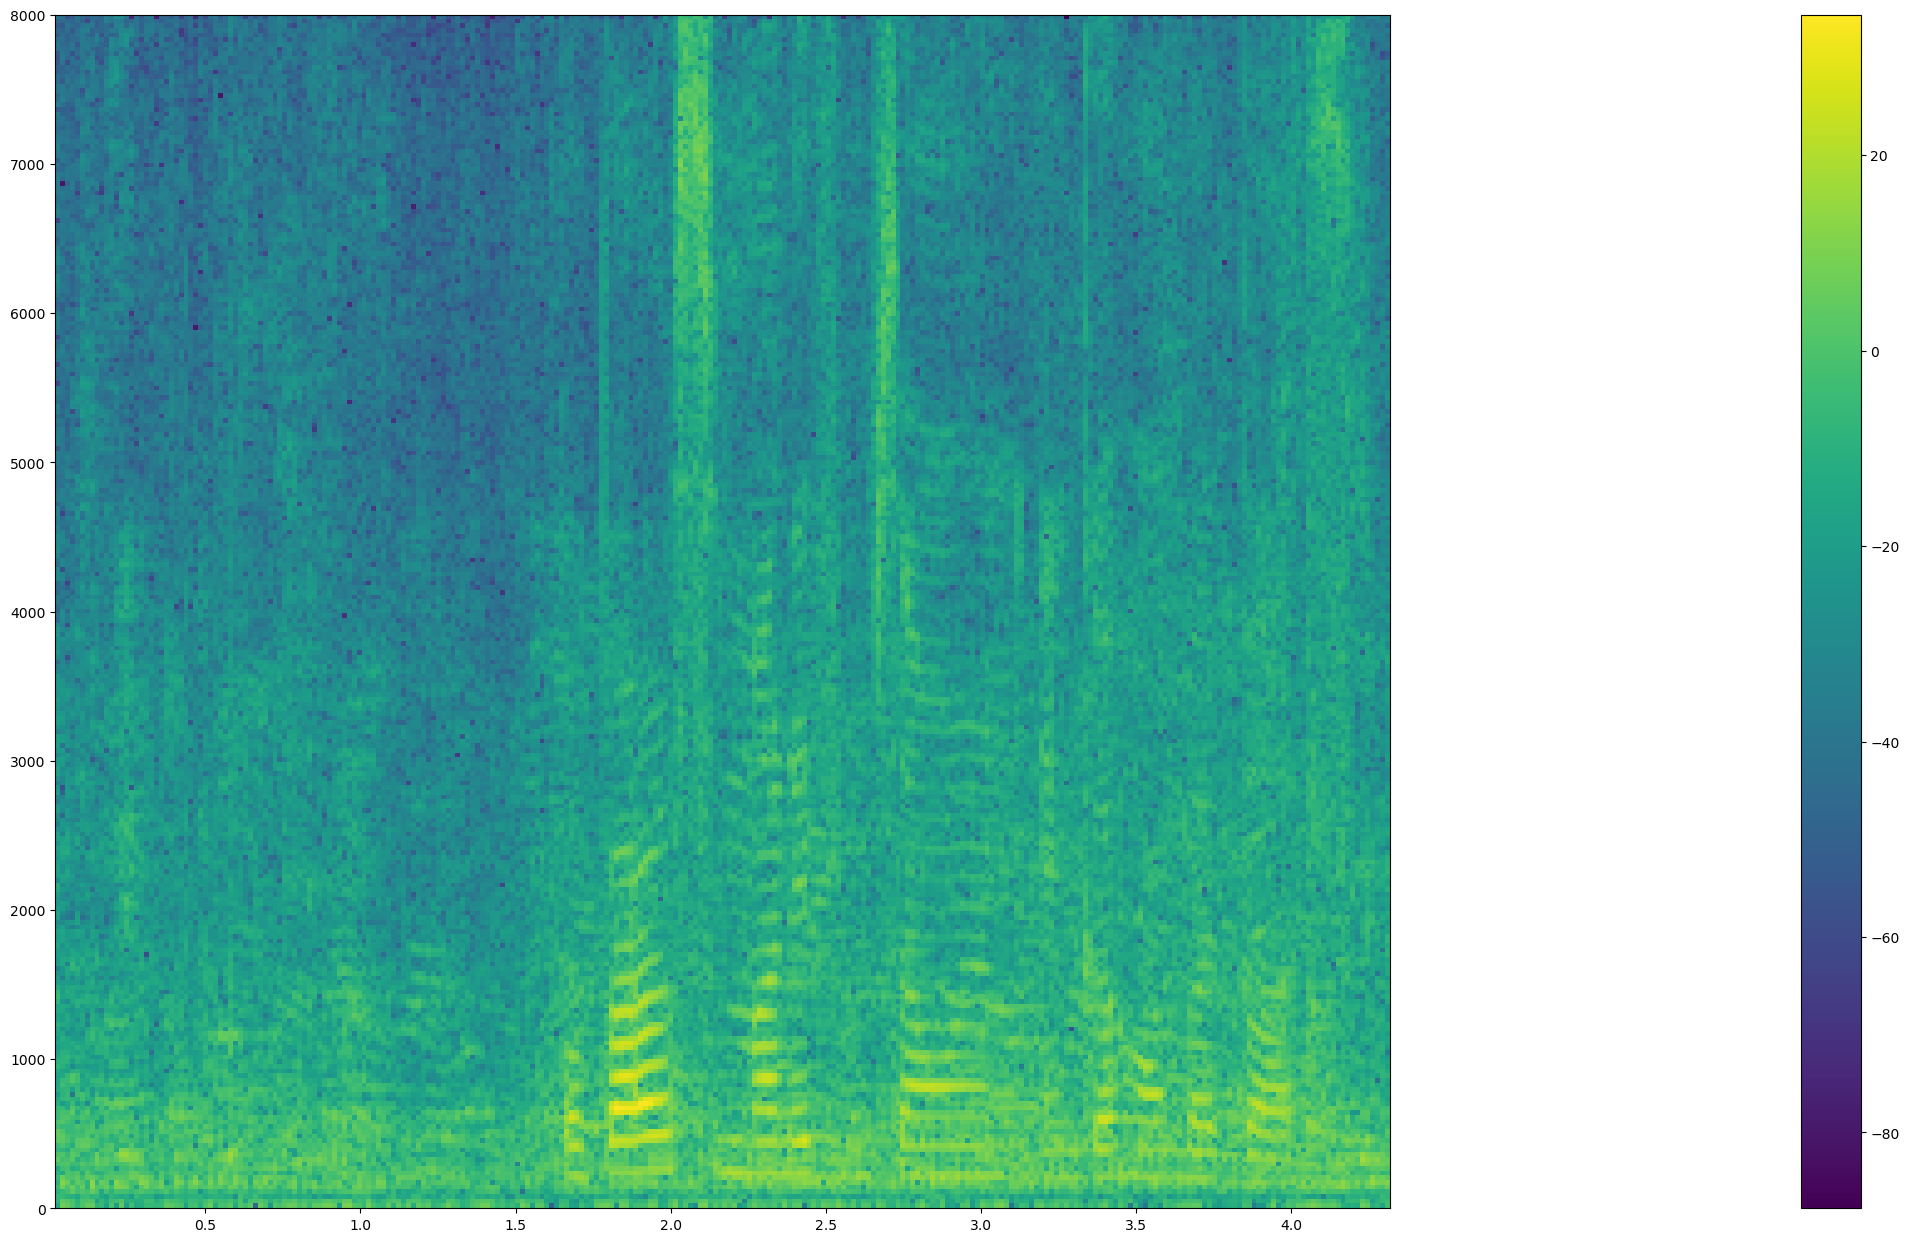

In [73]:
plot_spectrogram(babble_data)

1.2.c) Yes. we see that the images of the SPP and spectrogram are similar in shape. For example we can see the harmonics and noise areas in both images.

In [74]:
def plot_spectrogram_nostft(m_stft, v_time_frame, v_freq, vmin=None, vmax=None):
    fig = plt.figure()
    fig.set_size_inches(26.5, 15.5)
    ax = fig.add_subplot(111)
    im = ax.imshow(10*np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**(-15))),
                   cmap='viridis', origin='lower', extent=[v_time_frame[0], v_time_frame[-1], v_freq[0],
                                                           sampling_rate//2], aspect='auto', vmin=vmin, vmax=vmax)
    fig.colorbar(im, orientation="vertical", pad=0.2)

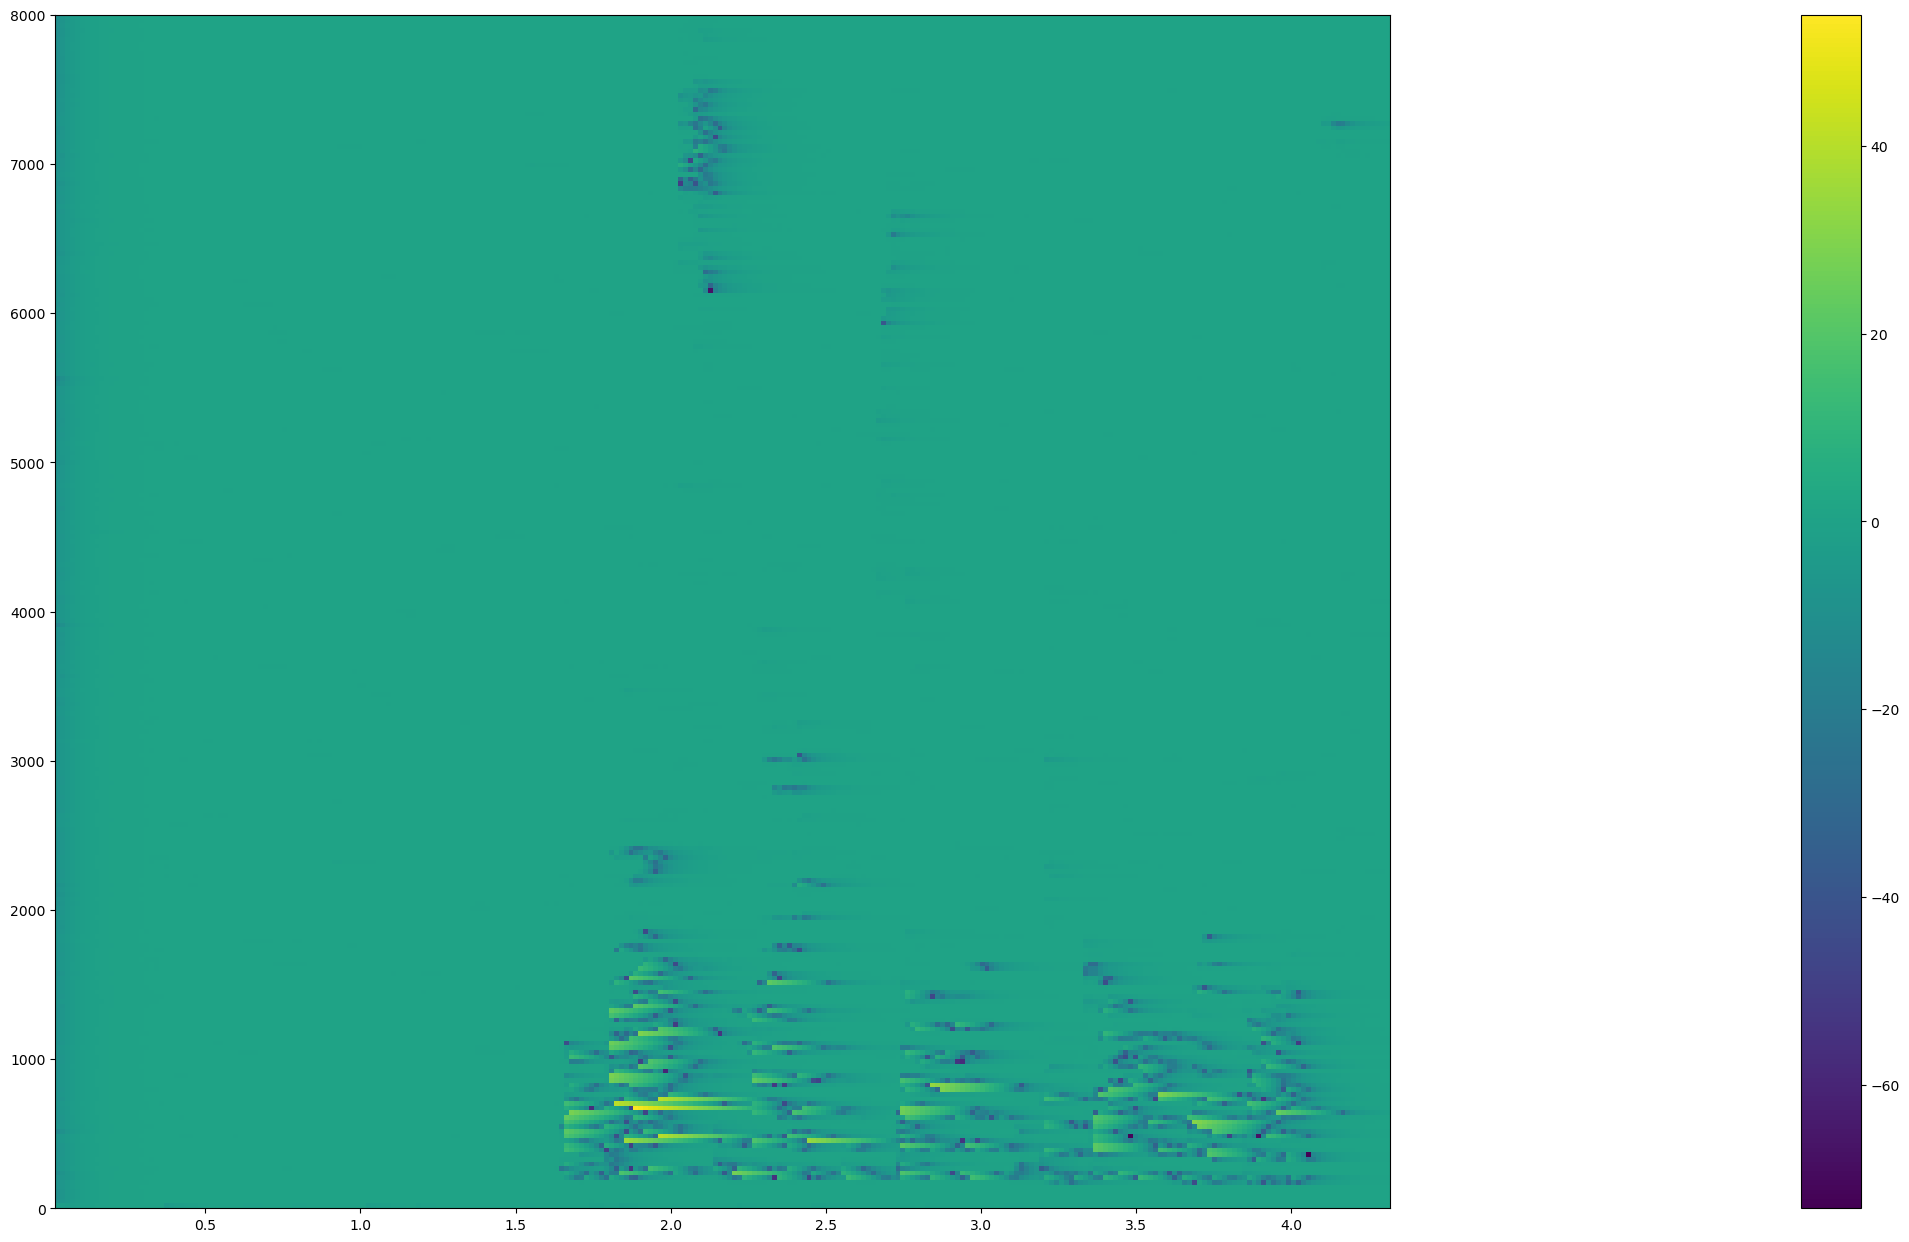

In [75]:
plot_spectrogram_nostft(m_noise_psd_white, v_time_frame_white, v_freq_white)

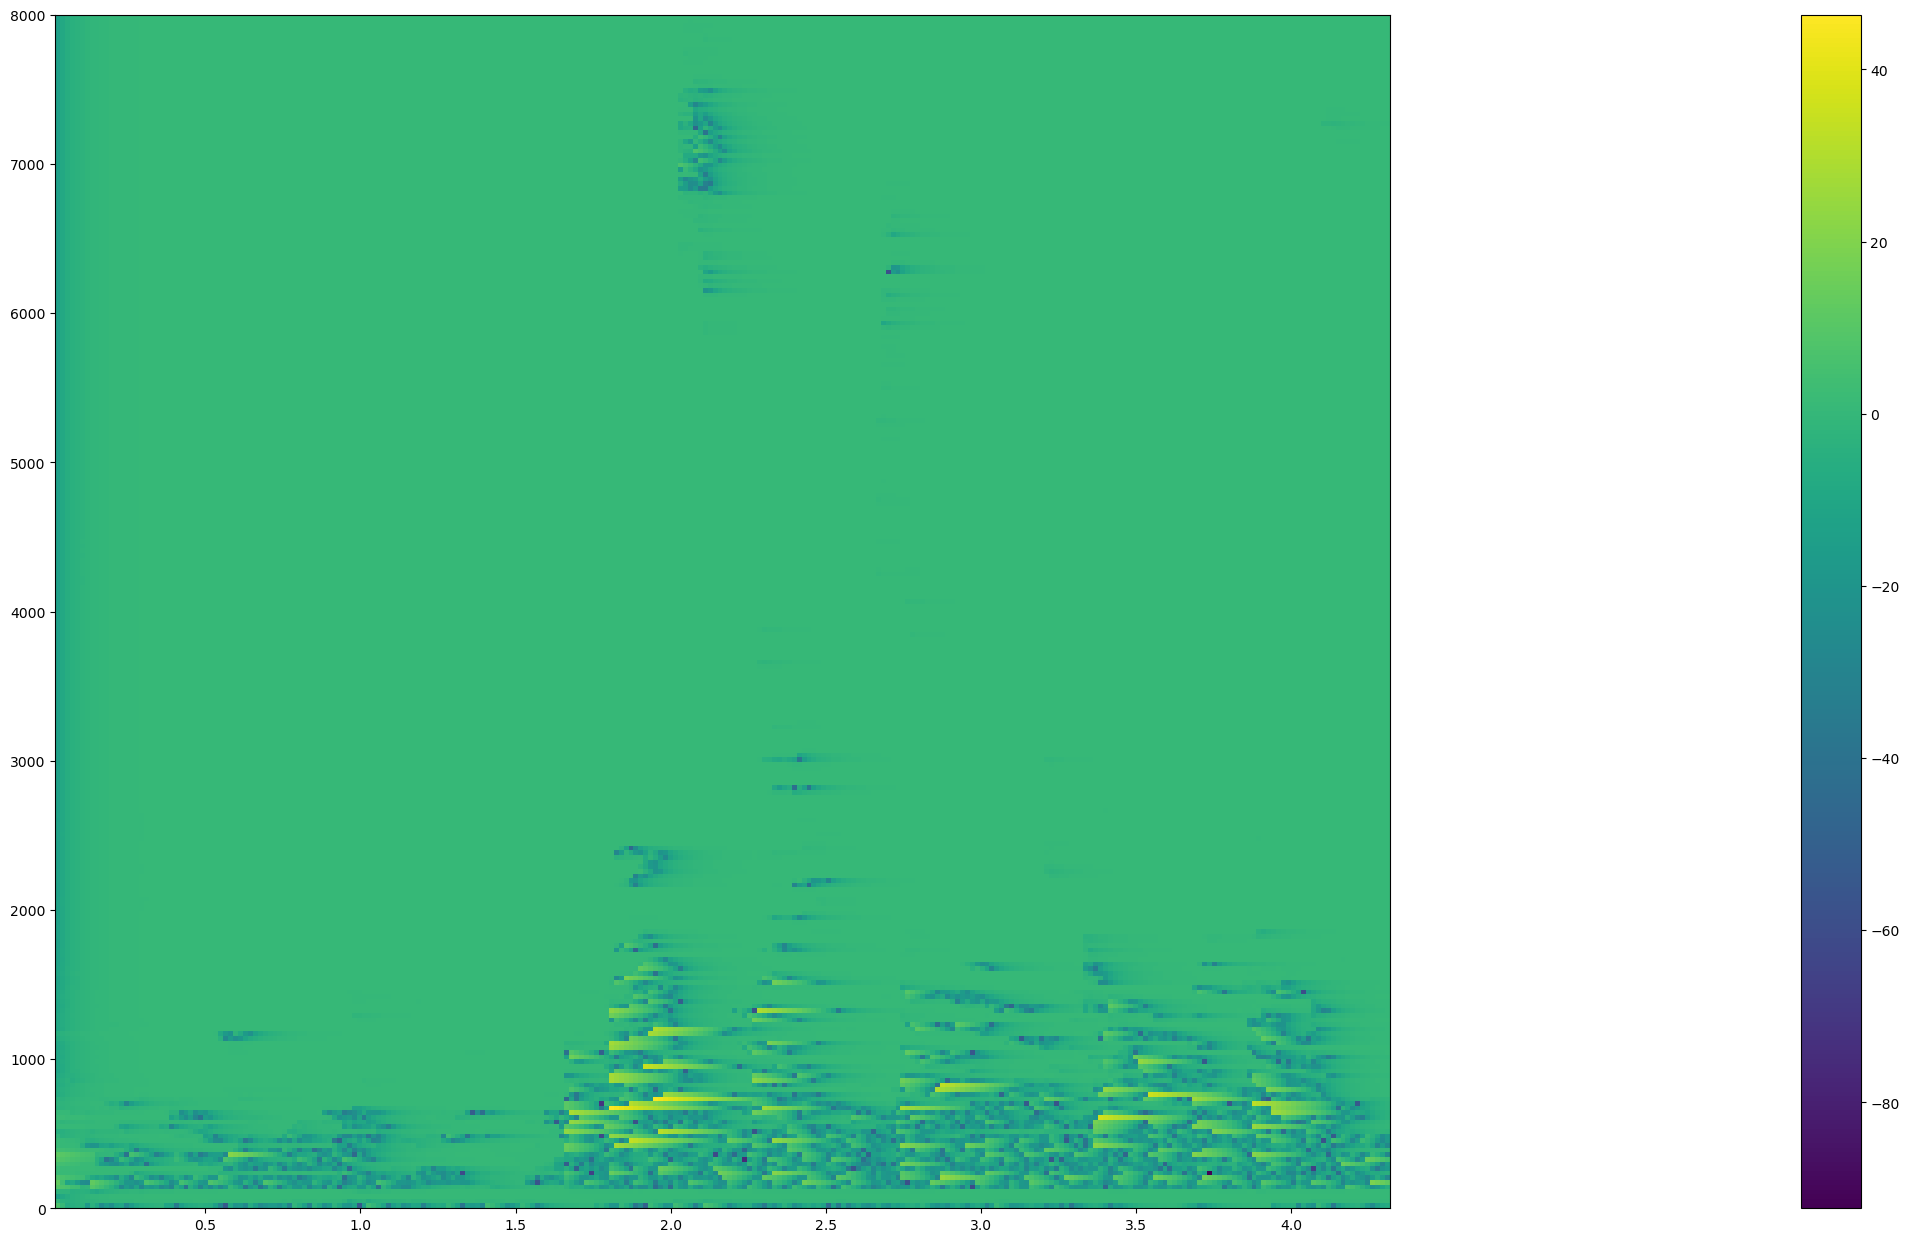

In [76]:
plot_spectrogram_nostft(m_noise_psd_babble, v_time_frame_babble, v_freq_babble)

1.3.a) good.

1.3.b) Yes, we can see the speech presence too.

1.3.c) A consequence is if we use the noise PSD to suppress noise from a speech signal and we see components that belong to the speech we might also suppress the speech signal.


In [173]:
#2)

In [77]:
def compute_apriori_snr_internal(m_stft, initial_s, initial_noise_psd, alpha, l):
    left = alpha*(np.square(np.abs(initial_s))/initial_noise_psd)
    periodogram = np.square(np.abs(m_stft[l]))
    right = (1-alpha)*np.maximum((periodogram/initial_noise_psd) - 1.0, 0)
    apriori_snr = left + right
    return apriori_snr

def compute_wiener_filter_gain(m_apriori_snr, g_min, l):
    return np.maximum(m_apriori_snr[l]/(1+m_apriori_snr[l]), g_min)

def compute_enhanced_stft(m_stft, m_noise_psd, initial_s, initial_noise_psd, alpha, g_min):
    m_apriori_snr = np.zeros(m_stft.shape)
    m_enhanced_stft = np.zeros(m_stft.shape, dtype=np.complex64)
    g = np.zeros(m_stft.shape, dtype=np.complex64)
    for l in range(m_stft.shape[0]):
        m_apriori_snr[l] = compute_apriori_snr_internal(m_stft, initial_s, initial_noise_psd, alpha, l)
        g[l] = compute_wiener_filter_gain(m_apriori_snr, g_min, l)
        m_enhanced_stft[l] = g[l]*m_stft[l]
        initial_s = m_enhanced_stft[l]
        initial_noise_psd = m_noise_psd[l]
    return m_enhanced_stft

In [78]:
alpha = 0.5
g_min = 0.0

In [79]:
initial_s = np.zeros(m_stft_white.shape[1])
initial_s
initial_psd_noise_white = np.mean(np.square(np.abs(m_stft_white[0:m_stft_white.shape[0]//4])), axis=0)
m_enhanced_stft_white = compute_enhanced_stft(m_stft_white, m_noise_psd_white, initial_s, initial_psd_noise_white, alpha, g_min)
m_enhanced_stft_white

array([[ 0.0000000e+00+0.0000000e+00j, -6.0565922e-02-4.4070131e-01j,
         8.7914899e-02+4.1386774e-01j, ...,
         2.7207306e-02-5.5558155e-03j,  0.0000000e+00+0.0000000e+00j,
        -2.3468722e-02+0.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j, -1.1037170e-01+1.1018569e-01j,
         8.4477797e-02+2.3853106e-02j, ...,
        -9.4009141e-05-3.7185522e-04j,  0.0000000e+00-0.0000000e+00j,
        -5.0082032e-05+0.0000000e+00j],
       [ 5.5400145e-01+0.0000000e+00j, -1.6970513e-02-1.2960205e-04j,
         4.5496197e-03+2.7808859e-03j, ...,
        -5.6428313e-08+7.8374235e-08j,  0.0000000e+00-0.0000000e+00j,
         1.2992689e-09+0.0000000e+00j],
       ...,
       [ 9.8082173e-09+0.0000000e+00j, -0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, ...,
        -0.0000000e+00+0.0000000e+00j,  0.0000000e+00-0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 4.5677059e-17+0.0000000e+00j, -0.0000000e+00+0.0000000e+00j,
         0.0000000e+00

In [80]:
initial_s = np.zeros(m_stft_white.shape[1])
initial_s
initial_psd_noise_babble = np.mean(np.square(np.abs(m_stft_white[0:m_stft_babble.shape[0]//4])), axis=0)
m_enhanced_stft_babble = compute_enhanced_stft(m_stft_babble, m_noise_psd_babble, initial_s, initial_psd_noise_babble, alpha, g_min)
m_enhanced_stft_babble

array([[ 0.0000000e+00+0.0000000e+00j, -6.1718360e-02+1.7970242e-01j,
         2.7978349e-01+2.3776525e-01j, ...,
         0.0000000e+00-0.0000000e+00j, -0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 1.8367168e+00+0.0000000e+00j, -8.5546184e-01+3.8156590e-01j,
         9.8685496e-02+3.6114004e-02j, ...,
        -0.0000000e+00+0.0000000e+00j,  0.0000000e+00-0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 1.7123064e+00+0.0000000e+00j, -6.4930075e-01-6.7907959e-01j,
        -1.1958709e-04-8.8066363e-04j, ...,
        -0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       ...,
       [-4.2316899e-01+0.0000000e+00j,  9.4452881e-09+6.6497114e-09j,
         0.0000000e+00+0.0000000e+00j, ...,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
        -0.0000000e+00+0.0000000e+00j],
       [ 1.0370739e-01+0.0000000e+00j,  1.3085849e-17+3.9573905e-17j,
         0.0000000e+00

2.1) By listening to both audios we can determine that there is no speech signal in the first second, so the estimated for the clean speech can be initialized to zero.

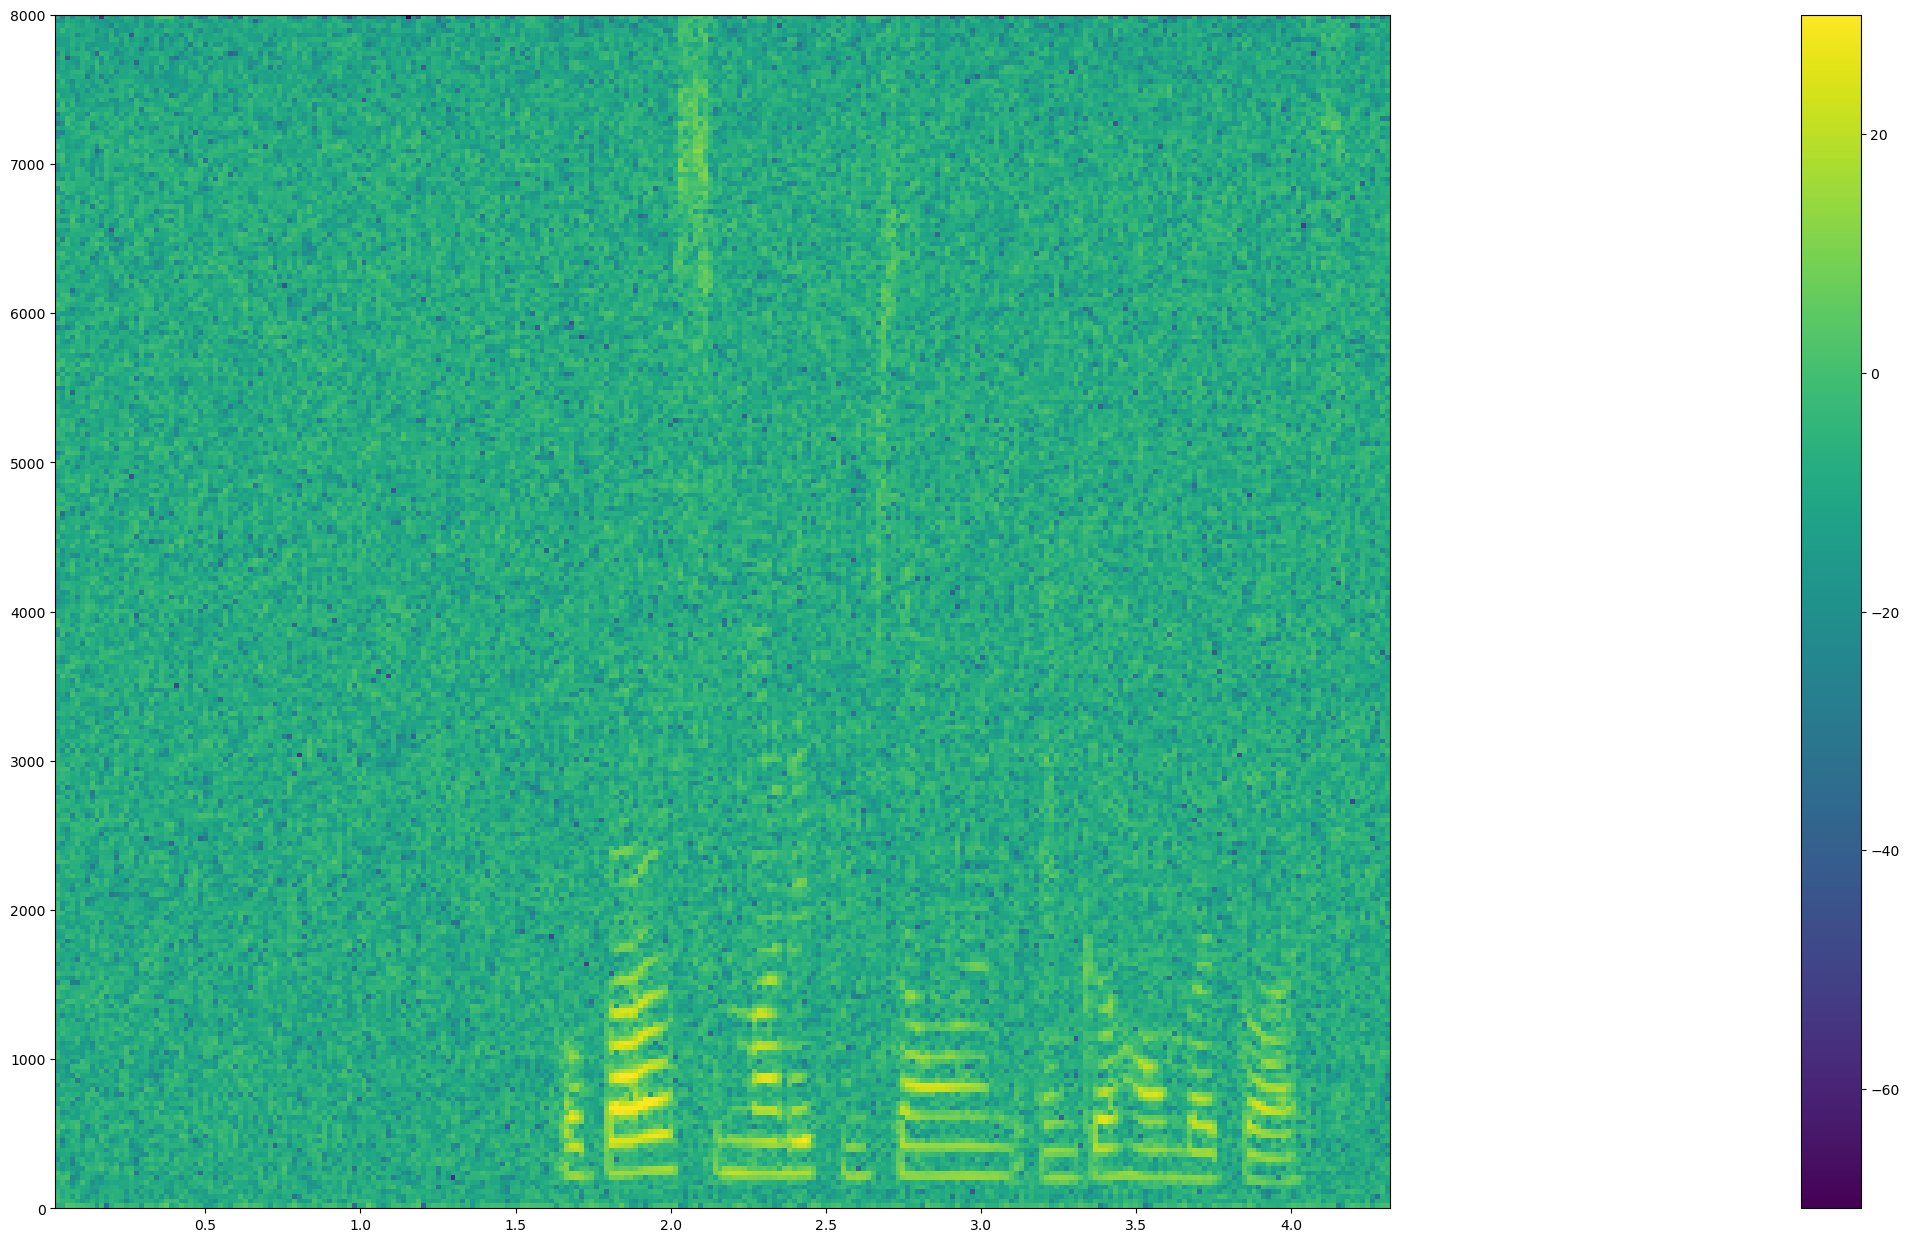

In [81]:
plot_spectrogram_nostft(m_stft_white, v_time_frame_white, v_freq_white, vmin=-70, vmax=30)

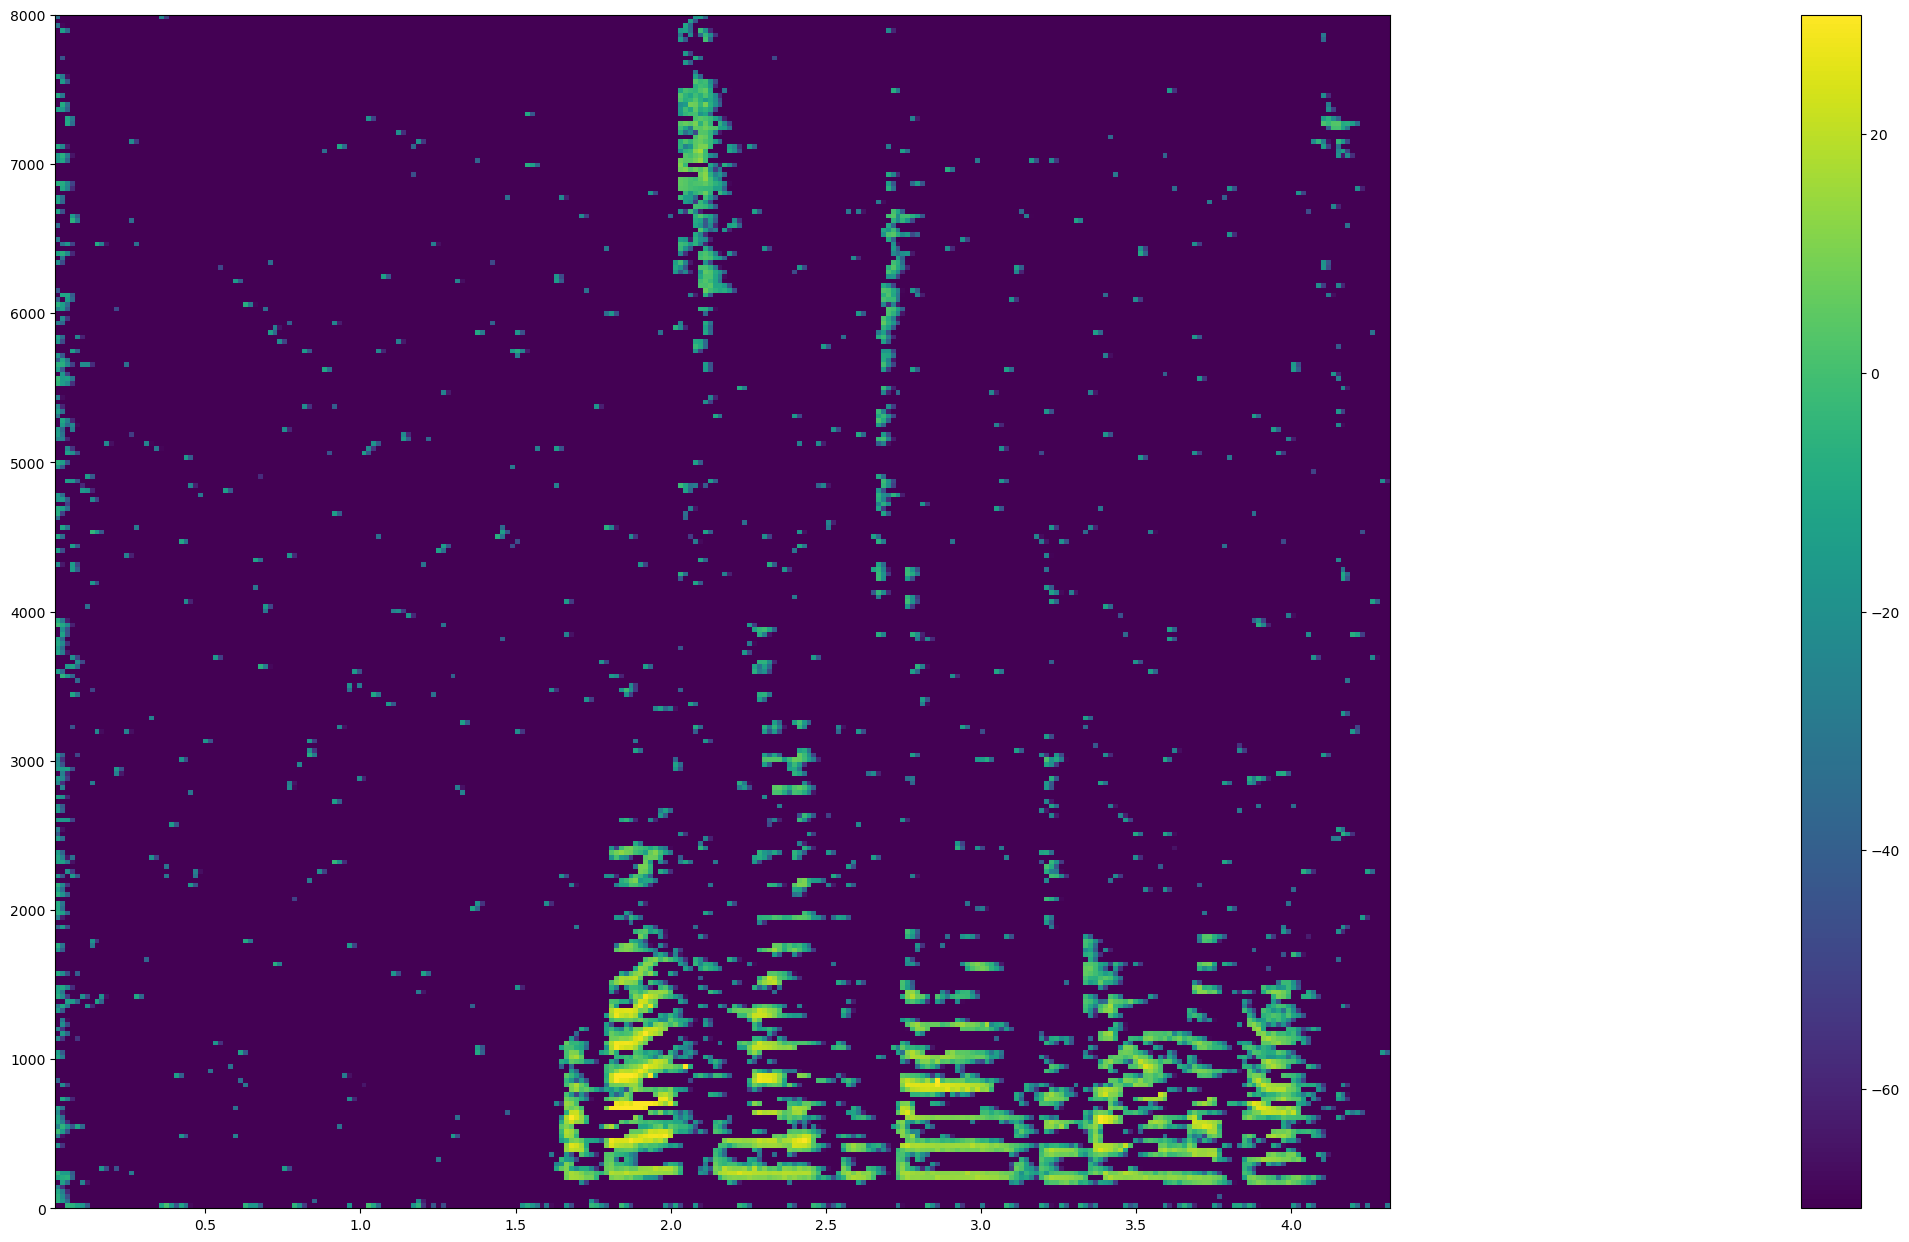

In [82]:
plot_spectrogram_nostft(m_enhanced_stft_white, v_time_frame_white, v_freq_white, vmin=-70, vmax=30)

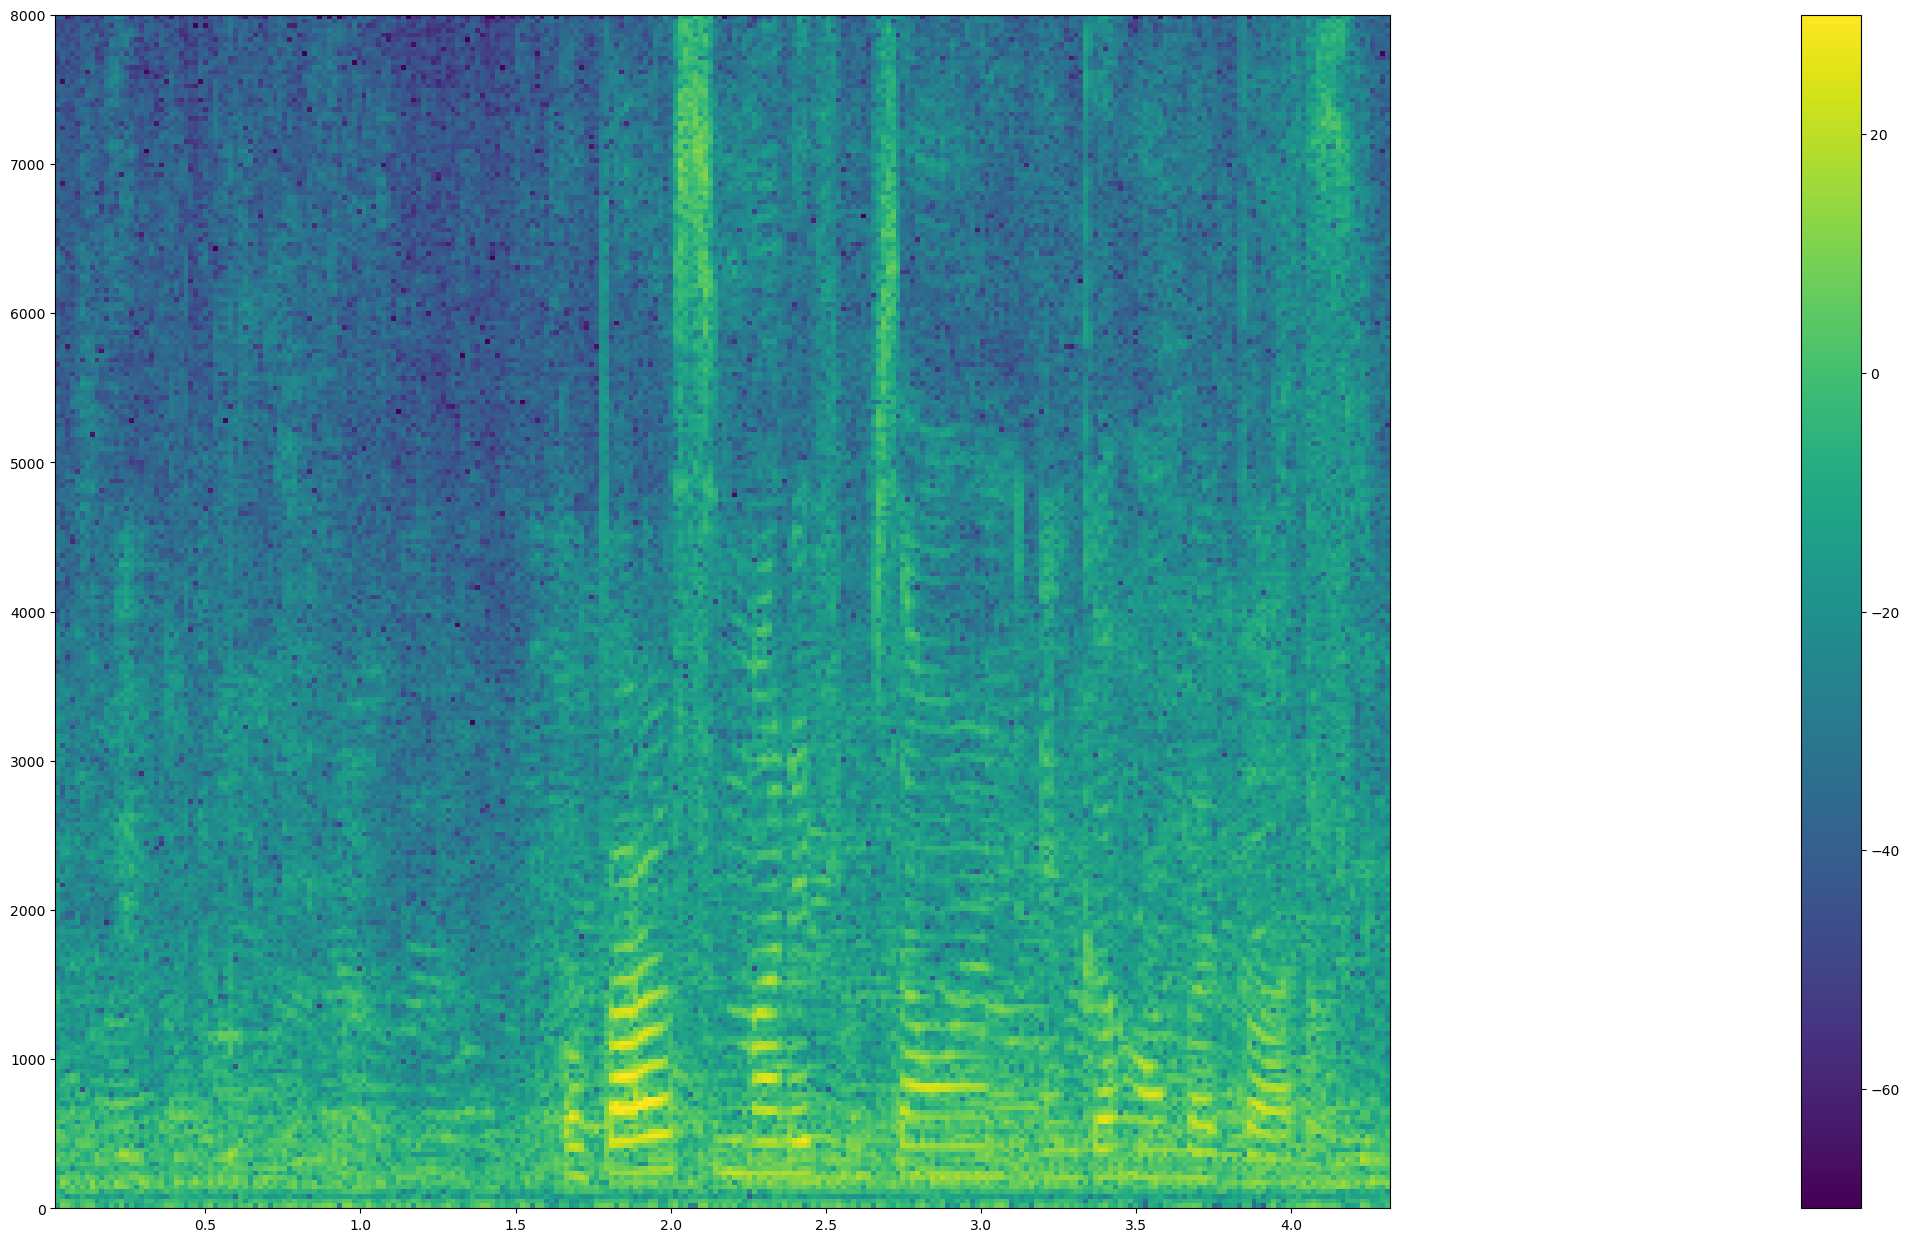

In [83]:
plot_spectrogram_nostft(m_stft_babble, v_time_frame_babble, v_freq_babble, vmin=-70, vmax=30)

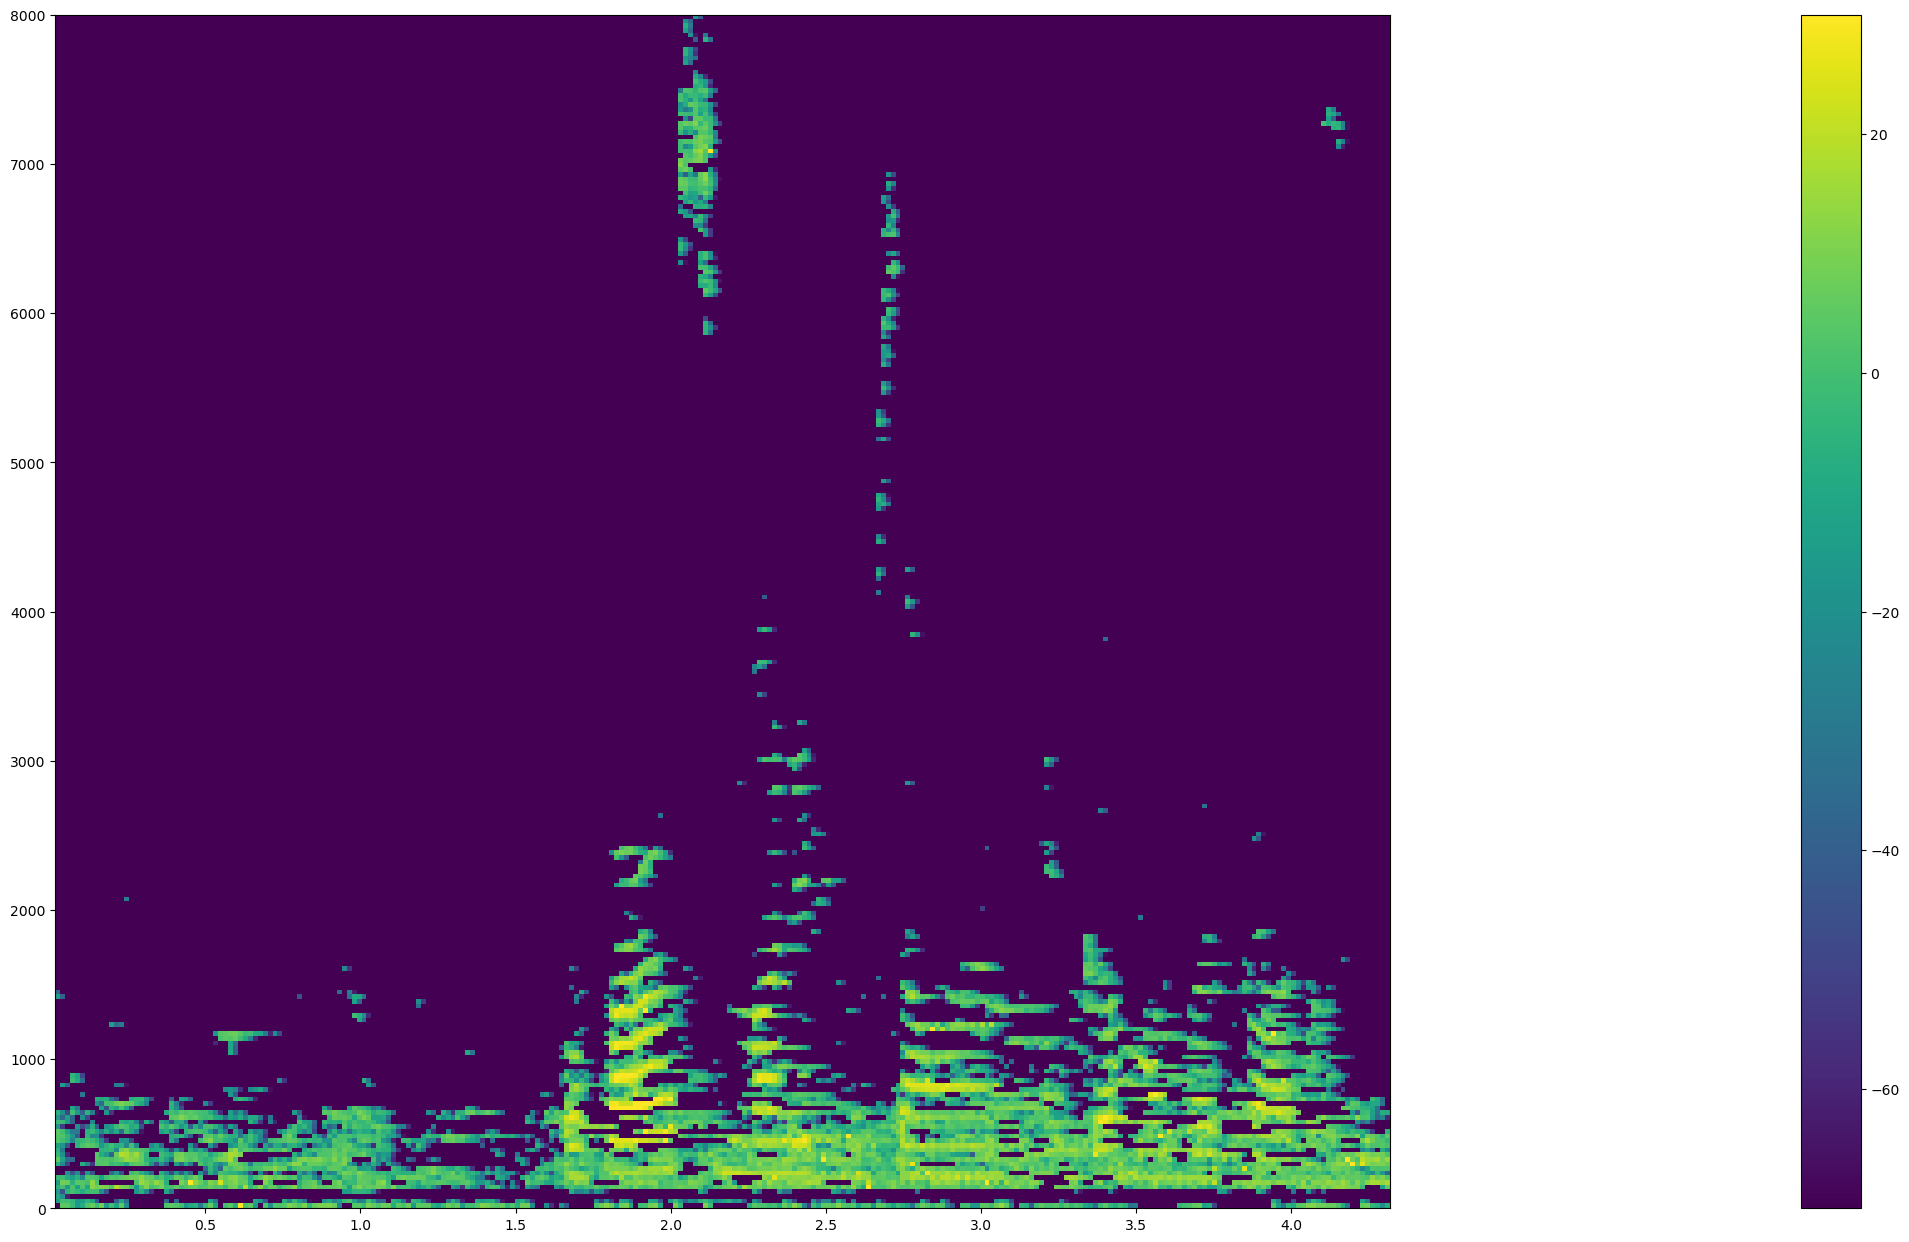

In [84]:
plot_spectrogram_nostft(m_enhanced_stft_babble, v_time_frame_babble, v_freq_babble, vmin=-70, vmax=30)

2.2.a)

2.2.b)

In [85]:
def convert_to_samples(milliseconds: int, sampling_freq: int):
    """
    Convert a millisecond duration into the number of samples given the sampling frequency.

    :param milliseconds: duration to be converted to number of samples
    :param sampling_freq: the sampling frequency
    :return: number of samples
    """
    return int(milliseconds * (10 ** (-3)) * sampling_freq)

def compute_istft(stft: np.ndarray, sampling_rate: int, frame_shift: int, synthesis_window: np.ndarray) -> [np.ndarray]:
    """
    Compute the inverse short-time Fourier transform.

    :param stft: STFT transformed signal
    :param sampling_rate: the sampling rate in Hz
    :param frame_shift: the frame shift used to compute the STFT in milliseconds
    :param synthesis_window: a numpy array containing a synthesis window function (length must match with time domain
    signal segments that were used to compute the STFT)
    :return: a numpy array containing the time domain signal
    """

    # compute inverse rFFT and apply synthesis window
    time_frames = np.fft.irfft(stft)
    num_frames, samples_per_frame = time_frames.shape
    assert samples_per_frame == len(synthesis_window), "Synthesis window must match the number of samples per frame."
    time_frames *= synthesis_window

    # compute output size
    samples_per_shift = convert_to_samples(frame_shift, sampling_rate)
    output_len = samples_per_frame + (num_frames - 1) * samples_per_shift
    time_signal = np.zeros((output_len))


    # reconstruct signal by adding overlapping windowed segments
    for i in range(num_frames):
        time_signal[i*samples_per_shift:i*samples_per_shift+samples_per_frame] += time_frames[i]

    return time_signal

In [86]:
#synthesis_window = get_window('hann', int(frame_length_samples), fftbins=True)
#root_hann = np.sqrt(synthesis_window)

In [112]:
enhanced_white_data = compute_istft(m_enhanced_stft_white, sampling_rate, frame_shift, root_hann)

In [113]:
sd.play(enhanced_white_data, sampling_rate)

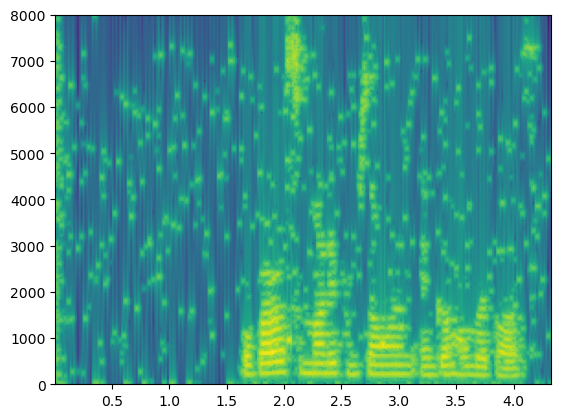

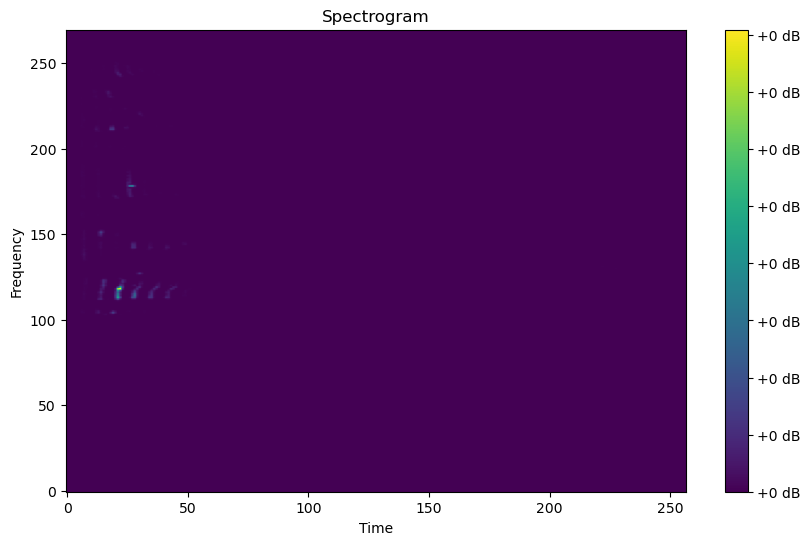

In [114]:
# Compute the spectrogram of the time-domain signal
spectrogram, _, _, _ = plt.specgram(enhanced_white_data, NFFT=512, Fs=sampling_rate, noverlap=256)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(spectrogram.T), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [90]:
enhanced_babble_data = compute_istft(m_enhanced_stft_babble, sampling_rate, frame_shift, root_hann)

In [116]:
sd.play(enhanced_babble_data, sampling_rate)

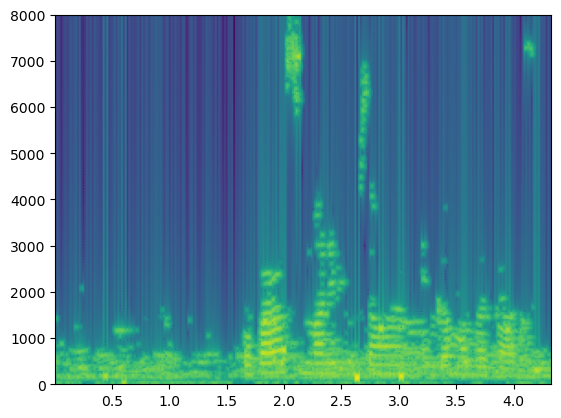

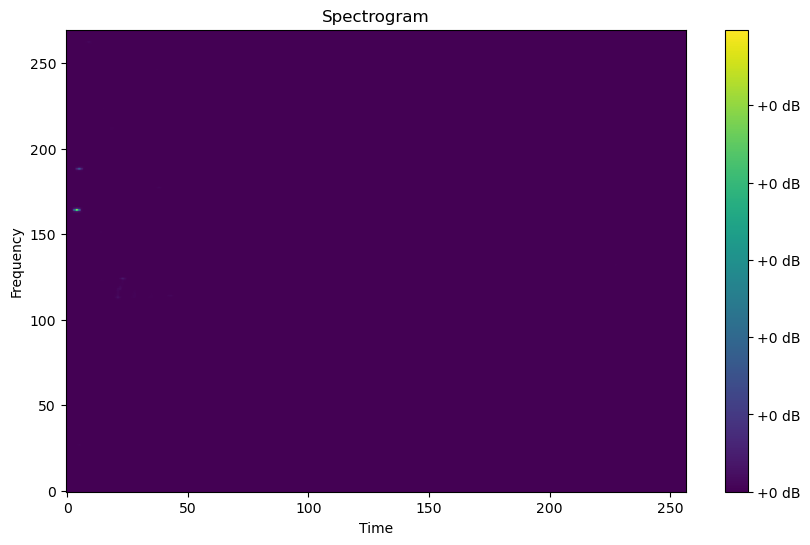

In [115]:
# Compute the spectrogram of the time-domain signal
spectrogram, _, _, _ = plt.specgram(enhanced_babble_data, NFFT=512, Fs=sampling_rate, noverlap=256)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(spectrogram.T), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

3.1.a) Both signals have well removed background noises, but a little are still audible.

3.1.b) There are small distortions within speech signal, but the speech is well and clearly heard.

3.1.c) Within the signal, we are able to hear distortion and echo.

In [92]:
#3.2)
initial_psd_noise_white = np.mean(np.square(np.abs(m_stft_white[0:m_stft_white.shape[0]//4])), axis=0)

initial_psd_noise_babble = np.mean(np.square(np.abs(m_stft_babble[0:m_stft_babble.shape[0]//4])), axis=0)

initial_q = np.zeros(m_stft_white.shape[1])

initial_s = np.zeros(m_stft_white.shape[1])


def denoise_signal(data=None, sampling_rate=None, frame_length=None, frame_shift=None, analysis_window=None, theta=15, alpha=0.5, g_min=0.0, initial_psd_noise=None, initial_q=None, initial_s=None):
    m_stft, v_freq, v_time_frame = compute_stft(data, sampling_rate, frame_length, frame_shift, analysis_window)
    periodogram = np.square(np.abs(m_stft))
    m_spp, m_noise_psd = compute_spp(periodogram, np.copy(initial_psd_noise), np.copy(initial_q), theta)
    m_enhanced_stft = compute_enhanced_stft(m_stft, m_noise_psd, np.copy(initial_s), np.copy(initial_psd_noise), alpha, g_min)
    enhanced_data = compute_istft(m_enhanced_stft, sampling_rate, frame_shift, root_hann)
    my_dict = {
        'm_stft': m_stft,
        'v_freq': v_freq,
        'v_time_frame': v_time_frame,
        'm_spp': m_spp,
        'm_noise_psd': m_noise_psd,
        'm_enhanced_stft': m_enhanced_stft,
        'enhanced_data': enhanced_data
    }
    return my_dict

In [93]:
#best list 0.9 > 0.6 > 0.5 > 0.4

dict_white = denoise_signal(
    data=white_data, sampling_rate=sampling_rate, frame_length=frame_length, frame_shift=frame_shift,
    analysis_window=root_hann, theta=15, alpha=0.9, g_min=0.0, initial_psd_noise=initial_psd_noise_white,
    initial_q=initial_q, initial_s=initial_s)

/var/folders/89/bjtd11g52mxg5l5fn598w6h00000gn/T/ipykernel_42402/4065776803.py:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(exp_numerator/(exp_denominator))


In [94]:
sd.play(dict_white['enhanced_data'], sampling_rate)

In [106]:
print(dict_white.keys())

dict_keys(['m_stft', 'v_freq', 'v_time_frame', 'm_spp', 'm_noise_psd', 'm_enhanced_stft', 'enhanced_data'])


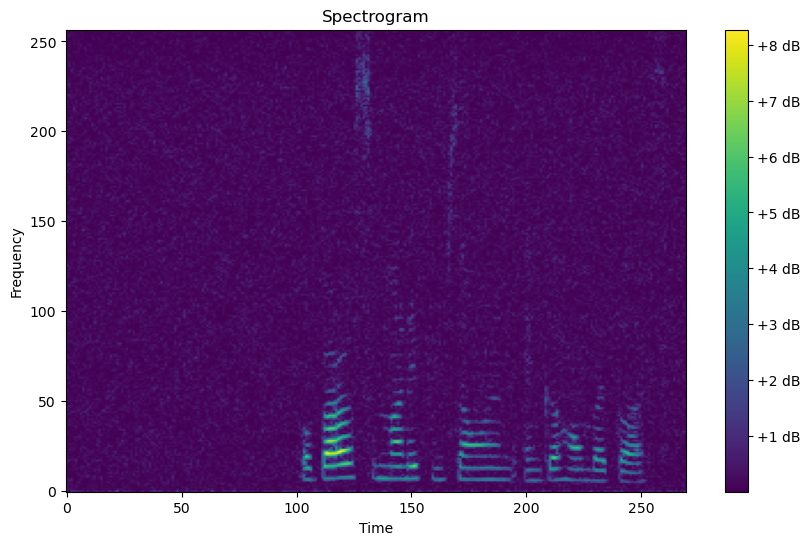

In [117]:
# Get the spectrogram of the denoised signal
spectrogram = np.abs(dict_white['m_stft']) ** 2

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(spectrogram.T), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## 3.3

In [95]:
#0.0 is best

dict_white = denoise_signal(
    data=white_data, sampling_rate=sampling_rate, frame_length=frame_length, frame_shift=frame_shift,
    analysis_window=root_hann, theta=15, alpha=0.9, g_min=0.0, initial_psd_noise=initial_psd_noise_white,
    initial_q=initial_q, initial_s=initial_s)

/var/folders/89/bjtd11g52mxg5l5fn598w6h00000gn/T/ipykernel_42402/4065776803.py:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(exp_numerator/(exp_denominator))


In [100]:
sd.play(dict_white['enhanced_data'], sampling_rate)